In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import os
import time
import PIL
from torchinfo import summary

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset

In [2]:
data_dir = 'dogs-vs-cats'

train_set_dir = os.path.join(data_dir, 'train')
valid_set_dir = os.path.join(data_dir, 'valid')
test_set_dir = os.path.join(data_dir, 'test')

In [3]:
print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validation set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 20000
the number of validation set : 2500
the number of test set : 2500


In [4]:
# torch.utils.data.Dataset을 사용하여 custom dataset 만들기
# 참고: https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

# 레이블을 지정하는 경우 자주 사용하게 될 듯
class CustomDataset(Dataset):
    '''
    __init__(self, files, root, mode='train', transform=None) : 클래스를 생성할 때 실행되는 생성자
        ㄴfiles : 이미지 파일 이름을 저장하고 있는 list
        ㄴroot : 이미지 파일이 존재하는 폴더 경로
        ㄴmode : 해당 dataset이 학습용인지 평가용인지 체크
        ㄴtransform : 이미지의 전처리를 위한 torchvision.transform
    '''    
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform = transform
        
        # 이미지 파일의 이름에 'cat'이 포함되어 있을 경우
        if 'cat' in files[0]:
            # 고양이 이미지 레이블 - 0
            self.label = 0
        else:
            # 강아지 이미지 레이블 - 1
            self.label = 1
            
    '''
    __len__(self) : Dataset의 길이를 반환하기 위한 메소드
    '''              
    def __len__(self):
        return len(self.files)
    
    '''
    __getitem__(self, index) : 클래스의 인덱스에 접근할 때 자동으로 호출되는 메소드
                               주어진 key에 해당하는 data를 반환하며,
                               key에 해당하는 이미지 파일을 읽고, 전처리 과정을 통해서 data를 리턴합니다. 
                               mode='train'일 경우에는 label을 반환하고, 'train'용이 아닌 경우에는 label을 모르기 때문에 
                               실제 이미지 파일의 경로를 반환하도록 합니다.
    '''        
    def __getitem__(self, index):
        # 이미지 불러오기(경로, 인덱스)
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        # 이미지 전처리
        if self.transform:
            img = self.transform(img)
        # 학습 이미지 리턴 (이미지, 레이블)
        if self.mode == 'train':
            return img, np.array([self.label])
        # 테스트 이미지 리턴
        else:
            return img, self.files[index]        

In [5]:
train_transform = transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((299, 299)),
                                    transforms.ToTensor()])

In [6]:
dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)

valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)

test_dog_dataset = CustomDataset(dog_files[11250:12500], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:12500], test_set_dir, transform=test_transform)

train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [8]:
test_dataset[0][0].shape

torch.Size([3, 299, 299])

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

----------------------------------------------------------------------------------------------------------------------------------------

## Inception V3

![1](https://blog.paperspace.com/content/images/2020/03/image-8.png)
![2](https://miro.medium.com/v2/resize:fit:960/1*gqKM5V-uo2sMFFPDS84yJw.png)

In [10]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, bias=False, **kwargs),
                                        nn.BatchNorm2d(out_channels, eps=0.001),
                                        nn.ReLU())
    def forward(self, x):
        x = self.conv_block(x)
        return x

class InceptionA(nn.Module):
    def __init__(self, in_channels, pool_features):
        super().__init__()

        self.branch3x3dbl = nn.Sequential(BasicConv2d(in_channels, 64, kernel_size=1), # dbl = double
                                          BasicConv2d(64, 96, kernel_size=3, padding=1),
                                          BasicConv2d(96, 96, kernel_size=3, padding=1))
        
        self.branch3x3 = nn.Sequential(BasicConv2d(in_channels, 48, kernel_size=1),
                                       BasicConv2d(48, 64, kernel_size=3, padding=1))

        self.branch_pool = nn.Sequential(nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
                                         BasicConv2d(in_channels, pool_features, kernel_size=1))
        
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

    def forward(self, x):
        x = [self.branch3x3dbl(x), self.branch3x3(x), self.branch_pool(x), self.branch1x1(x)]
        return torch.cat(x,1)

class ReductionA(nn.Module): # Bottleneck 피하면서 grid-size 줄이기
    def __init__(self, in_channels):
        super().__init__()

        self.branch3x3dbl = nn.Sequential(BasicConv2d(in_channels, 64, kernel_size=1),
                                          BasicConv2d(64, 96, kernel_size=3, padding=1),
                                          BasicConv2d(96, 96, kernel_size=3, stride=2))
        
        self.branch3x3 = nn.Sequential(BasicConv2d(in_channels, 64, kernel_size=1),
                                       BasicConv2d(64, 384, kernel_size=3, stride=2))
        

        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        x = [self.branch3x3dbl(x), self.branch3x3(x), self.branch_pool(x)]
        return torch.cat(x,1)

class InceptionB(nn.Module):
    def __init__(self, in_channels, channels_7x7):
        super().__init__()

        c7 = channels_7x7
        self.branch7x7dbl = nn.Sequential(BasicConv2d(in_channels, c7, kernel_size=1),
                                          BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(3, 0)), # 7x1, 1x7 순으로 되어있던 것을 논문이랑 같게 순서 바꿈
                                          BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(0, 3)),
                                          BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(3, 0)),
                                          BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(0, 3)))
        
        self.branch7x7 = nn.Sequential(BasicConv2d(in_channels, c7, kernel_size=1),
                                       BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3)),
                                       BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0)))
        
        self.branch_pool = nn.Sequential(nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
                                         BasicConv2d(in_channels, 192, kernel_size=1))
        
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        x = [self.branch7x7dbl(x), self.branch7x7(x), self.branch_pool(x), self.branch1x1(x)]
        return torch.cat(x,1)

class ReductionB(nn.Module): # Bottleneck 피하면서 grid-size 줄이기
    def __init__(self, in_channels):
        super().__init__()

        self.branch3x3dbl = nn.Sequential(BasicConv2d(in_channels, 192, kernel_size=1),
                                          BasicConv2d(192, 192, kernel_size=3, padding=1),
                                          BasicConv2d(192, 192, kernel_size=3, stride=2))
        
        self.branch3x3 = nn.Sequential(BasicConv2d(in_channels, 192, kernel_size=1),
                                       BasicConv2d(192, 320, kernel_size=3, stride=2))

        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
    def forward(self, x):
        x = [self.branch3x3dbl(x), self.branch3x3(x), self.branch_pool(x)]
        return torch.cat(x,1)

class InceptionC(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch3x3dbl = nn.Sequential(BasicConv2d(in_channels, 448, kernel_size=1),
                                          BasicConv2d(448, 384, kernel_size=3, padding=1))
        self.branch3x3dbla = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dblb = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = nn.Sequential(nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
                                         BasicConv2d(in_channels, 192, kernel_size=1))

        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

    def forward(self, x):
        branch3x3dbl = self.branch3x3dbl(x)
        branch3x3dbl = [self.branch3x3dbla(branch3x3dbl),
                        self.branch3x3dblb(branch3x3dbl)]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch3x3 = self.branch3x3(x)
        branch3x3 = [self.branch3x3a(branch3x3),
                     self.branch3x3b(branch3x3)]
        branch3x3 = torch.cat(branch3x3, 1)

        branch_pool = self.branch_pool(x)

        branch1x1 = self.branch1x1(x)

        outputs = [branch3x3dbl, branch3x3, branch_pool, branch1x1]
        return torch.cat(outputs,1)

class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.avgpool1 = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv2a = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv2b = BasicConv2d(128, 1024, kernel_size=1) # FC 라고 써있긴 한데,
        # GAP를 해야 image size가 달라졌을 때 error가 안날거라 GAP 가 어딘가 쓰이는 게 좋을 거 같은데
        # GAP 를 먼저 하자니 128x1x1 로 너무 확 줄어서 1024로 늘린 다음 GAP 하는 것으로 1024x1x1을 만들었다
        self.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)
        self.fc.stddev = 0.001

    def forward(self, x):
        # N x 768 x 17 x 17
        x = self.avgpool1(x)
        # N x 768 x 5 x 5
        x = self.conv2a(x)
        # N x 128 x 5 x 5
        x = self.conv2b(x)
        # N x 1024 x 5 x 5
        x = self.avgpool2(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.fc(x)
        # N x 1000
        return x

class Inception_V3(nn.Module):
    def __init__(self, num_classes = 1000, use_aux = True, init_weights = None, drop_p = 0.5):
        super().__init__()

        self.use_aux = use_aux

        self.conv1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv1b = BasicConv2d(32, 32, kernel_size=3)
        self.conv1c = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2a = BasicConv2d(64, 80, kernel_size=3)
        self.conv2b = BasicConv2d(80, 192, kernel_size=3, stride=2)
        self.conv2c = BasicConv2d(192, 288, kernel_size=3, padding=1)

        self.inception3a = InceptionA(288, pool_features=64)
        self.inception3b = InceptionA(288, pool_features=64)
        self.inception3c = ReductionA(288)
        
        self.inception4a = InceptionB(768, channels_7x7=128)
        self.inception4b = InceptionB(768, channels_7x7=160)
        self.inception4c = InceptionB(768, channels_7x7=160)
        self.inception4d = InceptionB(768, channels_7x7=192)
        if use_aux:
            self.aux = InceptionAux(768, num_classes)
        else:
            self.aux = None
        self.inception4e = ReductionB(768)

        self.inception5a = InceptionC(1280)
        self.inception5b = InceptionC(2048)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=drop_p)
        self.fc = nn.Linear(2048, num_classes)

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    stddev = float(m.stddev) if hasattr(m, "stddev") else 0.1  # type: ignore
                    torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=stddev, a=-2, b=2)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # N x 3 x 299 x 299
        x = self.conv1a(x)
        # N x 32 x 149 x 149
        x = self.conv1b(x)
        # N x 32 x 147 x 147
        x = self.conv1c(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.conv2a(x)
        # N x 80 x 71 x 71
        x = self.conv2b(x)
        # N x 192 x 35 x 35
        x = self.conv2c(x)
        # N x 288 x 35 x 35
        x = self.inception3a(x)
        # N x 288 x 35 x 35
        x = self.inception3b(x)
        # N x 288 x 35 x 35
        x = self.inception3c(x)
        # N x 768 x 17 x 17
        x = self.inception4a(x)
        # N x 768 x 17 x 17
        x = self.inception4b(x)
        # N x 768 x 17 x 17
        x = self.inception4c(x)
        # N x 768 x 17 x 17
        x = self.inception4d(x)
        # N x 768 x 17 x 17

        if self.aux is not None and self.training:
            aux = self.aux(x)
        else:
            aux = None  # 뭐라도 넣어놔야 not defined error 안 뜸

        x = self.inception4e(x)
        # N x 1280 x 8 x 8
        x = self.inception5a(x)
        # N x 2048 x 8 x 8
        x = self.inception5b(x)
        # N x 2048 x 8 x 8
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux

In [11]:
model = Inception_V3()

from torchinfo import summary
summary(model, input_size=(2,3,299,299), device='cpu')

Layer (type:depth-idx)                        Output Shape              Param #
Inception_V3                                  [2, 1000]                 1,256,680
├─BasicConv2d: 1-1                            [2, 32, 149, 149]         --
│    └─Sequential: 2-1                        [2, 32, 149, 149]         --
│    │    └─Conv2d: 3-1                       [2, 32, 149, 149]         864
│    │    └─BatchNorm2d: 3-2                  [2, 32, 149, 149]         64
│    │    └─ReLU: 3-3                         [2, 32, 149, 149]         --
├─BasicConv2d: 1-2                            [2, 32, 147, 147]         --
│    └─Sequential: 2-2                        [2, 32, 147, 147]         --
│    │    └─Conv2d: 3-4                       [2, 32, 147, 147]         9,216
│    │    └─BatchNorm2d: 3-5                  [2, 32, 147, 147]         64
│    │    └─ReLU: 3-6                         [2, 32, 147, 147]         --
├─BasicConv2d: 1-3                            [2, 64, 147, 147]         --
│    └─Se

In [12]:
x, aux = model(torch.randn(2, 3, 299, 299))
print(x.shape)
print(aux.shape)

torch.Size([2, 1000])
torch.Size([2, 1000])


----------------------------------------------------------------------------------------------------------------------------------------

## Using pretrained model: Inception V3

In [13]:
model_inceptionV3 = torchvision.models.inception_v3(pretrained=True)
model_inceptionV3

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [14]:
fc_layer = model_inceptionV3.fc.in_features
fc_layer

2048

In [15]:
model_inceptionV3.fc = nn.Sequential(nn.Linear(fc_layer, 1024),
                                    nn.ReLU(),
                                    nn.Linear(1024, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 1),
                                    nn.Sigmoid()
                                    )

In [16]:
model_inceptionV3.to(device)
summary(model_inceptionV3, input_size=(2, 3, 299, 299), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [2, 1]                    3,326,696
├─BasicConv2d: 1-1                       [2, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [2, 32, 149, 149]         864
│    └─BatchNorm2d: 2-2                  [2, 32, 149, 149]         64
├─BasicConv2d: 1-2                       [2, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [2, 32, 147, 147]         9,216
│    └─BatchNorm2d: 2-4                  [2, 32, 147, 147]         64
├─BasicConv2d: 1-3                       [2, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [2, 64, 147, 147]         18,432
│    └─BatchNorm2d: 2-6                  [2, 64, 147, 147]         128
├─MaxPool2d: 1-4                         [2, 64, 73, 73]           --
├─BasicConv2d: 1-5                       [2, 80, 73, 73]           --
│    └─Conv2d: 2-7                       [2, 80, 73, 73]           5,

In [20]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred.logits, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.logits.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    plt.plot(train_accuracies, label='train accuracy')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()
    plt.title('accuracy')
    plt.show()

In [21]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_inceptionV3.parameters(), lr=1e-5)

156.932sec : [Epoch 1/10] -> train loss: 0.0703, train acc: 97.270% / valid loss: 0.0271, valid acc: 98.920%
153.351sec : [Epoch 2/10] -> train loss: 0.0613, train acc: 97.545% / valid loss: 0.0234, valid acc: 99.040%
158.844sec : [Epoch 3/10] -> train loss: 0.0536, train acc: 97.895% / valid loss: 0.0240, valid acc: 99.200%
158.785sec : [Epoch 4/10] -> train loss: 0.0545, train acc: 97.810% / valid loss: 0.0228, valid acc: 99.120%
155.726sec : [Epoch 5/10] -> train loss: 0.0486, train acc: 98.025% / valid loss: 0.0226, valid acc: 99.160%
151.265sec : [Epoch 6/10] -> train loss: 0.0441, train acc: 98.295% / valid loss: 0.0220, valid acc: 99.120%
148.631sec : [Epoch 7/10] -> train loss: 0.0427, train acc: 98.300% / valid loss: 0.0206, valid acc: 99.200%
148.864sec : [Epoch 8/10] -> train loss: 0.0409, train acc: 98.300% / valid loss: 0.0202, valid acc: 99.160%
148.835sec : [Epoch 9/10] -> train loss: 0.0435, train acc: 98.180% / valid loss: 0.0214, valid acc: 98.920%
147.303sec : [Epoch

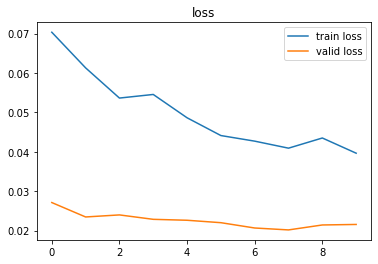

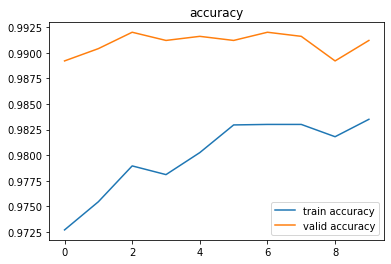

In [22]:
fit(model_inceptionV3, criterion, optimizer, 10, train_loader, valid_loader)

In [23]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')

In [25]:
eval(model_inceptionV3, criterion, test_loader)

eval loss: 0.0199, eval acc: 99.200%


In [26]:
test_dir = 'dogs-vs-cats/test1'
submit_files = [f'{i}.jpg' for i in range(1, 12500+1)]
submit_dataset = CustomDataset(submit_files, test_dir, mode='test', transform=test_transform)
submit_loader = torch.utils.data.DataLoader(submit_dataset, batch_size=128, shuffle=False)

In [28]:
def predict(model, data_loader):
    with torch.no_grad():
        model.eval()
        ret = None
        for img, files in data_loader:
            img = img.to(device)
            pred = model(img)
            
            if ret is None:
                ret = pred.cpu().numpy()
            else:
                ret = np.vstack([ret, pred.cpu().numpy()])
    return ret
   
pred = predict(model_inceptionV3, submit_loader)

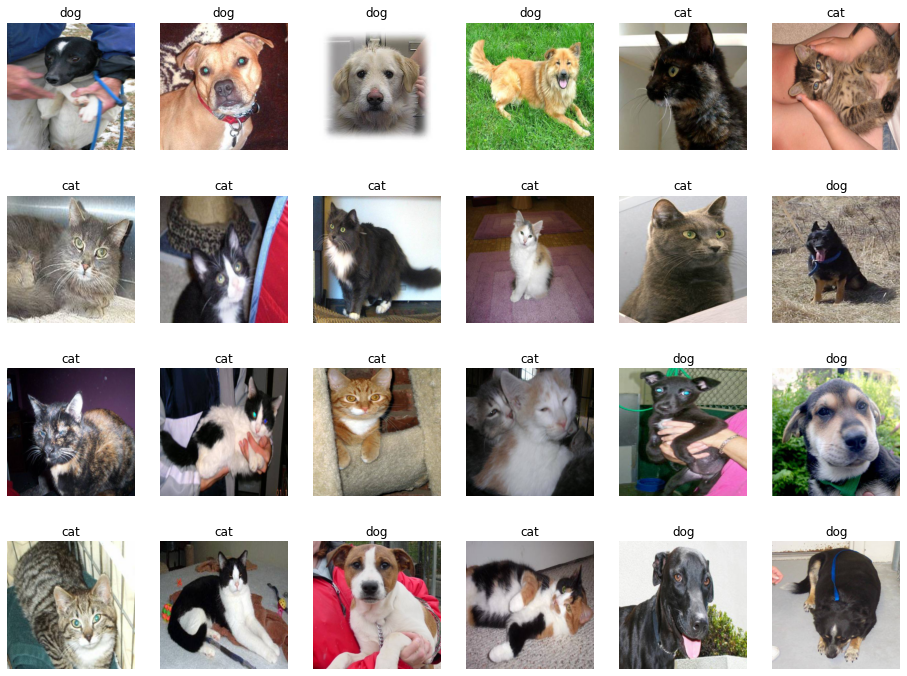

In [29]:
sample_pred = pred[:24]
sample_pred[sample_pred >= 0.5] = 1
sample_pred[sample_pred < 0.5] = 0
 
imgs, files = next(iter(submit_loader))
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[sample_pred[i][0]])
    a.axis('off')
    a.imshow(np.transpose(imgs[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)